# README

The goal of this project is to develop and train a long-short term memory neural network to detect toxic internet comments.

The dataset used in this task was taken from the Toxic Comment Classification Challenge by Jigsaw.

To achieve the goal, the following steps were taken:
1. General preprocessing:

    a. Generalizing the data for binary classification task
    
    b. Data visualization
    
2. Preprocessing for LSTM:

    a. Removing stop words

    b. Lemmatization

    c. Tokenization

    d. Vocabulary creation

3. Building an LSTM model with Pytorch

The project is still in progress, and the full results are yet to be seen.

Warning: Due to working with explicit data, the project contains elements that some may find offensive and obscene.

# 00 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import spacy

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# 01 General preprocessing

In [2]:
data = pd.read_csv('raw_data/raw_data.csv')
data.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
44927,781bd2f308138648,"HATE!!!!!!!!!!!!!!!!! \n\nWELL, I KNOW THAT YO...",1,0,0,0,1,0
146171,27fb463b7b87949d,However: if what you mean is that you want to ...,0,0,0,0,0,0
142386,f9a1546342c0d0e5,I guess its a valid point that I could look up...,0,0,0,0,0,0


In [3]:
# Generalization for binary classification task

data['label'] = (data.iloc[:, :-1] == 1).any(axis=1).astype(int)

data.drop(columns=['id', 'toxic', 'severe_toxic', 'obscene', 'threat',
                   'insult', 'identity_hate'], inplace=True)

data.sample(5)

,comment_text,label
38800,"22:40 EST, 4-Apr-2005",0
99106,"Not really, Mileena is a just fairly common ac...",0
5634,""":Provide reliable sources, or your edits will...",0
110235,"""\n\nKingdom Hearts 2 Theme Song-\n\nI know th...",0
23559,"""\nI am not calling it anything! I am not the...",0


In [4]:
data.shape

(159571, 2)

In [5]:
data[data['label'] == 1].sample(3)['comment_text']

121474    you fat asshole, why don't you leave my page a...
132062    Eddits \n\nWho the fuck are you to be reversin...
77182     are you dumb \n\nwhat the fuck are you talking...
Name: comment_text, dtype: object

In [6]:
# Checking for dulpicates

data['comment_text'].duplicated().sum()

0

In [7]:
data['comment_text'].dtype

dtype('O')

C:\Users\rados\AppData\Local\Temp\ipykernel_14528\2459196326.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


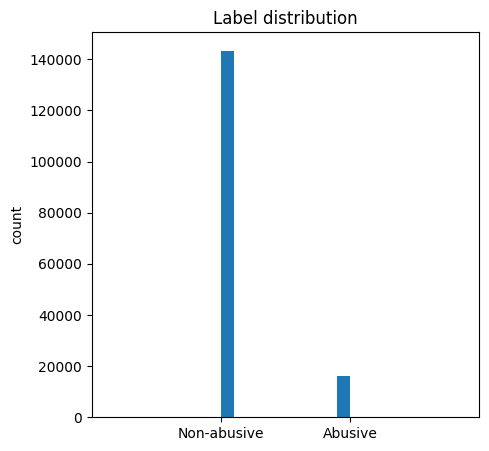

In [8]:
# Distribution of labels

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(data['label'])
ax.set_ylabel('count')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Non-abusive', 'Abusive'])
ax.set_xlim([-1, 2])
ax.set_title('Label distribution')
fig.show()

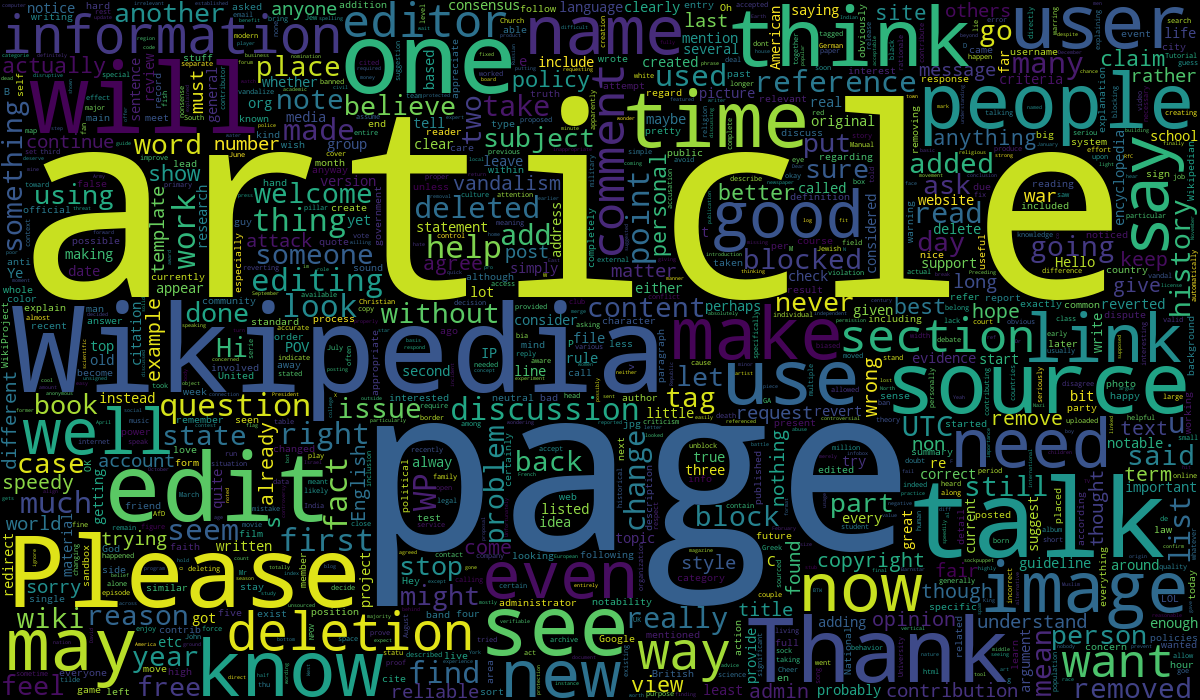

In [9]:
# Word Clouds

text_nonabusive = ' '.join(data[data['label']==0]['comment_text'])

wc_nonabusive = WordCloud(max_words=1000, width=1200,
                   height=700, collocations=False).generate(text_nonabusive)
wc_nonabusive.to_image()

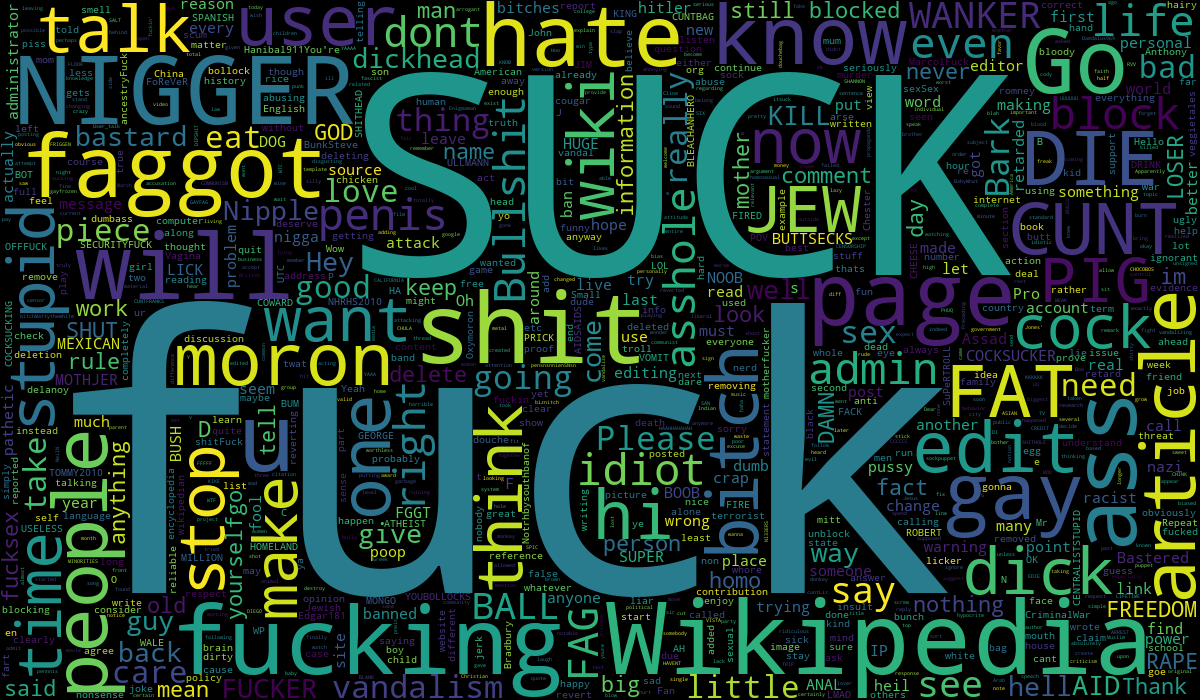

In [10]:
text_abusive = ' '.join(data[data['label']==1]['comment_text'])

wc_abusive = WordCloud(max_words=1000, width=1200,
                   height=700, collocations=False).generate(text_abusive)
wc_abusive.to_image()

# 02 LSTM

In [11]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])

In [12]:
# Removing stopwords

def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['comment_text'] = data['comment_text'].apply(remove_stopwords)

In [13]:
# Lemmatizing

# def lemmatize(text):
#   return ' '.join([x.lemma_ for x in nlp(text)])

# data['comment_text'] = data['comment_text'].apply(lemmatize)
# data.to_csv('preprocessed_data/lemmatized.csv')

data = pd.read_csv('preprocessed_data/lemmatized.csv', index_col=0)

In [14]:
data.sample(5)

,comment_text,label
126726,""" your recent question will please stop troll ...",0
129416,""" FYI , I rewrite offline ( as I main contribu...",0
53886,1 . correct 2 . pertinent 3 . good faith . so ...,1
14012,""" User : Qrc2006 yup , I would willing coach h...",0
29257,sourced material so sourced material bias fact...,0


In [15]:
# Splitting data

train_size=0.9
val_size=0.2

X_train, X_test, y_train, y_test = train_test_split(
    data['comment_text'], data['label'], train_size=train_size,
    stratify=data['label'], random_state=12)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=(val_size / train_size),
    stratify=y_train, random_state=42)


In [16]:
# Token generator

tokenizer = get_tokenizer('spacy', 'en_core_web_md')

def yield_tokens(iter):
  for text in iter:
    yield tokenizer(str(text).lower())

# Creating vocabulary

MAX_TOKENS = 50000

vocab = build_vocab_from_iterator(
    yield_tokens(X_train),
    specials=['<unk>'],
    max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

In [17]:
vocab(['I', 'like', 'trains'])

[0, 23, 45557]

In [18]:
# Preparing dataloaders

text_pipeline = lambda x: vocab(tokenizer(str(x)))

def collate_batch(batch):
  label_list, text_list, lenghts = [], [], []

  for _text, _label in batch:
    label_list.append(_label)
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    lenghts.append(processed_text.size(0))

  labels = torch.tensor(label_list, dtype=torch.float32)
  lenghts = torch.tensor(lenghts, dtype=torch.int64)
  texts = pad_sequence(text_list, batch_first=True)
  return texts, labels, lenghts

BATCH_SIZE = 128
train_dataloader = DataLoader(list(zip(X_train, y_train)), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(list(zip(X_val, y_val)), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(list(zip(X_test, y_test)), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [19]:
for i, X in enumerate(train_dataloader):
    print(X)
    if i == 2:
        break

(tensor([[  0, 322, 547,  ...,   0,   0,   0],
        [  0,  83, 370,  ...,   0,   0,   0],
        [  3, 348,   0,  ...,   0,   0,   0],
        ...,
        [  3,  11,  11,  ...,  16,   1,   3],
        [  3, 227,  40,  ...,   0,   0,   0],
        [ 29, 544,   8,  ...,   0,   0,   0]]), tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0.]), tensor([  7,  21,  29,  34,   4,  39,  37, 165,  66,  33,  88,  79,  18,  16,
         20, 106,  63,  29, 127, 230,  17,  27,  24,

In [20]:
# Creating an lstm model

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers):

        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):

        embedded = self.embedding(x)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (ht, ct) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        last_output = output[torch.arange(output.size(0)), lengths - 1, :]

        fc_output = self.fc(last_output)

        output_probabilities = self.sigmoid(fc_output)

        return output_probabilities

In [21]:
# Initializing lstm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 100
hidden_size = 50
output_size = 1
num_layers = 2

lstm = LSTM(MAX_TOKENS, embedding_dim, hidden_size, output_size, num_layers)
lstm = lstm.to(device)

device

device(type='cuda')

In [58]:
# Training lstm

criterion = nn.BCELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    
    for i, (texts, labels, lengths) in enumerate(train_dataloader):

        texts, labels = texts.to(device), labels.to(device)
        lstm.train()

        optimizer.zero_grad()
        outputs = lstm(texts, lengths)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:

            lstm.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for val_inputs, val_labels, val_lengths in val_dataloader:

                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    val_outputs = lstm(val_inputs, val_lengths)
                    val_loss += criterion(val_outputs.squeeze(), val_labels).item()

                    predicted = (val_outputs > 0.5).float().squeeze()
                    correct += (predicted == val_labels).sum().item()
                    total += val_labels.size(0)

            avg_val_loss = val_loss / len(val_dataloader)
            accuracy = 100 * correct / total

            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Validation Loss: {avg_val_loss:.4f}, Validation Acc: {accuracy:.2f}%')

            

Epoch [1/5], Step [100/873], Validation Loss: 0.2961, Validation Acc: 90.14
Epoch [1/5], Step [200/873], Validation Loss: 0.2478, Validation Acc: 91.32
Epoch [1/5], Step [300/873], Validation Loss: 0.2183, Validation Acc: 92.49
Epoch [1/5], Step [400/873], Validation Loss: 0.2032, Validation Acc: 93.11
Epoch [1/5], Step [500/873], Validation Loss: 0.2022, Validation Acc: 92.84
Epoch [1/5], Step [600/873], Validation Loss: 0.1742, Validation Acc: 93.86
Epoch [1/5], Step [700/873], Validation Loss: 0.1642, Validation Acc: 94.33
Epoch [1/5], Step [800/873], Validation Loss: 0.1655, Validation Acc: 94.41
Epoch [2/5], Step [100/873], Validation Loss: 0.1515, Validation Acc: 94.83
Epoch [2/5], Step [200/873], Validation Loss: 0.1493, Validation Acc: 94.72
Epoch [2/5], Step [300/873], Validation Loss: 0.1471, Validation Acc: 94.94
Epoch [2/5], Step [400/873], Validation Loss: 0.1372, Validation Acc: 95.16
Epoch [2/5], Step [500/873], Validation Loss: 0.1402, Validation Acc: 95.03
Epoch [2/5],

In [59]:
# Saving model params

lstm_path = 'models\lstm_valacc96_valloss012.pth'
torch.save(lstm.state_dict(), lstm_path)

In [59]:
# Loading lstm model

lstm_path = 'models\lstm_valacc96_valloss012.pth'
lstm.load_state_dict(torch.load(lstm_path))


<All keys matched successfully>

In [23]:
# Test data eval

lstm.eval()
criterion = nn.BCELoss()
tp = 0
tn = 0
fp = 0
fn = 0
test_loss = 0

with torch.no_grad():

    for (test_inputs, test_labels, test_lenghts) in test_dataloader:

        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        test_outputs = lstm(test_inputs, test_lenghts).squeeze()
        test_loss += criterion(test_outputs, test_labels).item()

        test_pred = (test_outputs > 0.5).float()
        tp += ((test_pred == 1) & (test_labels == 1)).sum().item()
        tn += ((test_pred == 0) & (test_labels == 0)).sum().item()
        fp += ((test_pred == 1) & (test_labels == 0)).sum().item()
        fn += ((test_pred == 0) & (test_labels == 1)).sum().item()

    total = (tp + tn + fp + fn)
    conf_matrix = torch.tensor([[tp, fp], [fn, tn]])
    test_acc = 100 * (tp + tn) / total
    avg_test_loss = test_loss / len(test_dataloader)

    print(f'Test acc: {test_acc:.2f}\nAvg test loss: {avg_test_loss:.4f}\nConfusion matrix: \n{conf_matrix}')

Test acc: 95.73
Avg test loss: 0.1246
Confusion matrix: 
tensor([[ 1158,   223],
        [  459, 14118]])


In [86]:
# Sentance test

your_sentence = 'The sun is shining, the children are playing'

def sentence_preproc(sentence):
   sentence = ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, sentence.split()))
   sentence = ' '.join([x.lemma_ for x in nlp(sentence)])
   tokens = tokenizer(sentence)
   sentence = torch.tensor([vocab(tokens)])
   sentence = sentence.to(device)
   length = torch.tensor([len(tokens)])
   return sentence, length

preproc_sentence, length = sentence_preproc(your_sentence)
prediction = lstm(preproc_sentence, length).item()
result = round(prediction)

print(f'Chance of being abusive: {(100 * prediction):.2f}%')
if result == 1:
   print(f'Your sentence: {your_sentence}\nPrediction: This is an abusive sentence')
else:
   print(f'Your sentence: {your_sentence}\nPrediction: This is a non-abusive sentence')

Chance of being abusive: 1.26%
Your sentence: The sun is shining, the children are playing
Prediction: This is a non-abusive sentence
